# Landmark-based Fingerprinting

This practical uses the audio fingerprinting code from https://github.com/dpwe/audfprint .
You should download it into a subdirectory alongside this notebook file.

This fingerprint, based on the description in [Avery Wang's paper](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf), arranges local peaks in the spectrogram into pairs, then builds an index mapping hashes based on the frequencies and time spacing of the pairs to every track that contains them.  A good match is found when multiple 
common hashes have the same relative timing in query and reference.

In [1]:
%pylab inline
from __future__ import print_function
import cPickle as pickle
import os
import IPython

import numpy as np

import librosa

#os.chdir('/Users/dpwe/Downloads/e4896/elene4896/prac12')
from audfprint import audfprint_analyze
from audfprint import audfprint_match
from audfprint import hash_table
from audfprint import audio_read


Populating the interactive namespace from numpy and matplotlib


In [2]:
def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', 
               origin='bottom', cmap='gray_r', **kwargs)

In [167]:
# Read in a local query file.
#filename = '01-Taxman.mp3'
filename = 'Come_Together.mp3'
d, sr = librosa.load(filename, sr=None)
print("sr=", sr, "d.shape=", d.shape)

sr= 16000 d.shape= (4171392,)


In [183]:
# The Analyzer object manages the creation of landmark hashes for the query.
analyzer = audfprint_analyze.Analyzer()
analyzer.target_sr = sr
analyzer.density = 10   # Target number of hashes per second.
peaks = analyzer.find_peaks(d, sr)
print("len(peaks)=", len(peaks))
print(peaks[:5])
frame_hop = 256   # Analyzer always uses 512 point FFTs with 256 point advance.
frame_rate = sr / float(frame_hop)
print("frame_rate=", frame_rate, "Hz")

len(peaks)= 1832
[(78, 100), (79, 108), (80, 81), (81, 161), (82, 122)]
frame_rate= 62.5 Hz


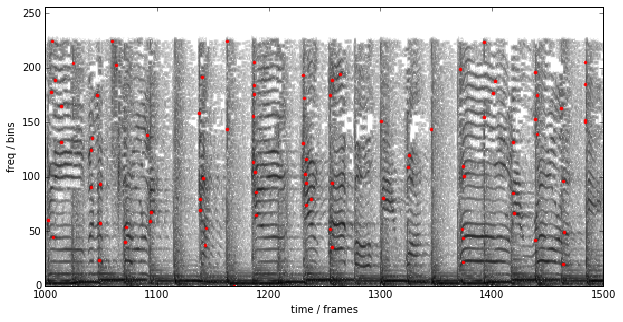

In [179]:
# Plot the peaks that were found over the equivalent spectrogram.
sgram = np.abs(librosa.stft(d, n_fft=512, hop_length=256))
plt.figure(figsize=(10,5))
my_imshow(20*np.log10(np.maximum(1e-3, sgram)))
x = [p[0] for p in peaks]
y = [p[1] for p in peaks]
plot(x, y, '.r')
xlim([1000, 1500])
ylim([0, 256])
xlabel("time / frames")
ylabel("freq / bins")

len(landmarks)= 2448
   t0  f1  f2  dt
[[ 78 100  81   2]
 [ 78 100 122   4]
 [ 78 100  92   6]
 [ 79 108 122   3]
 [ 79 108  92   5]]


(0, 256)

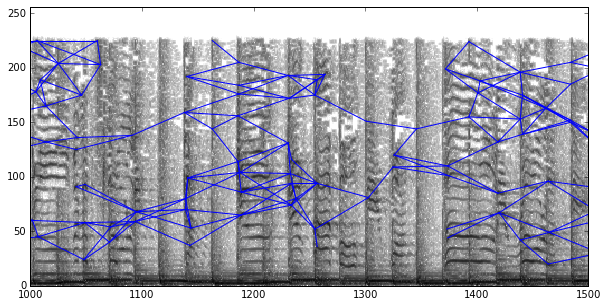

In [175]:
# Convert the individual peaks into landmark pairs by finding 
# nearby instances.
landmarks = np.array(analyzer.peaks2landmarks(peaks))
print("len(landmarks)=", len(landmarks))
# Each row of landmarks contains the start time bin, the start and end frequency bins, and the time separation.
print("   t0  f1  f2  dt")
print(landmarks[:5])
t0 = landmarks[:, 0]
f1 = landmarks[:, 1]
f2 = landmarks[:, 2]
dt = landmarks[:, 3]
# Plot the pairs over the spectrogram.
plt.figure(figsize=(10,5))
my_imshow(20*np.log10(np.maximum(1e-3, sgram)))
plot([t0, t0+dt], [f1, f2], '-b')
plot([t0, t0+dt], '.b')
xlim([1000, 1500])
ylim([0, 256])

In [184]:
# To look up in the database, each (f1, f2, dt) triple is converted into a 20-bit binary number.
hashes = audfprint_analyze.landmarks2hashes(landmarks)
print("len(hashes)=", len(hashes))
print("time  hash")
print(hashes[:5])

len(hashes)= 2448
time  hash
[(78, 412482), (78, 411012), (78, 413190), (79, 443267), (79, 445445)]


(0, 256)

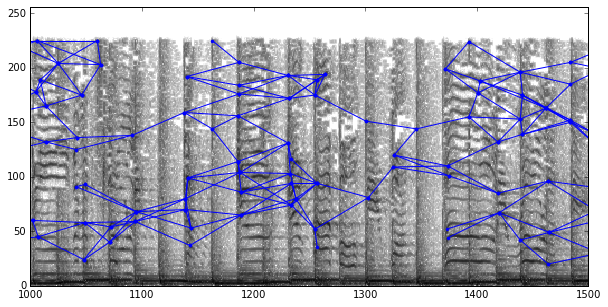

In [122]:
# We can still convert the hashes back into the (f1, f2, dt) triples and plot them on the spectrogram.
def show_hashes(hashes, d=None, sr=None, color='b'):
    """Plot the hashes on a spectrogram."""
    if d is not None:
        sgram = np.abs(librosa.stft(d, n_fft=512, hop_length=256))
        my_imshow(20*np.log10(np.maximum(1e-3, sgram)))
    landmarks = np.array(audfprint_analyze.hashes2landmarks(hashes))
    t0 = landmarks[:, 0]
    f1 = landmarks[:, 1]
    f2 = landmarks[:, 2]
    dt = landmarks[:, 3]
    plot([t0, t0 + dt], [f1, f2], '-' + color)
    plot([t0, t0 + dt], [f1, f2], '.' + color)

plt.figure(figsize=(10,5))
show_hashes(hashes, d, sr)
xlim([1000, 1500])
ylim([0, 256])

# Reference Database

`audfprint` will take a list of audio files and build a big database from all their hashes.
I precomputed one from the 32 kbps MP3 versions of the 8752 tracks that comprise
[uspop2002](http://labrosa.ee.columbia.edu/projects/musicsim/uspop2002.html).  For 
reference, the exact command is below.  I ran it on parallel on 8 cores and it took 
about 20 minutes to ingest all the files.

```
porkpie:/scratch/dpwe > time python ~/projects/audfprint/python/audfprint.py new -d uspop-n10-b20.fpdb -W ~drspeech/data/music/mp3s-32k -V .mp3 -r 16000 -l ~drspeech/data/music/mp3s-mp3s.txt -H 8 -n 10 -b 20
hash_table 0 has 1094 files 2616250 hashes
hash_table 1 has 1094 files 2654923 hashes
hash_table 2 has 1094 files 2636462 hashes
hash_table 3 has 1094 files 2710421 hashes
hash_table 4 has 1094 files 2620202 hashes
hash_table 5 has 1094 files 2692489 hashes
hash_table 6 has 1094 files 2647007 hashes
hash_table 7 has 1094 files 2643872 hashes
Saved fprints for 8752 files ( 21151809 hashes) to uspop-n10-b20.fpdb
Dropped hashes= 6571527 (31.07%)
16653.208u 1197.230s 37:32.89 792.3%    0+0k 0+109080io 0pf+0w
```

You can download the database as [uspop-n10-b20.fpdb](http://www.ee.columbia.edu/~dpwe/e4896/code/prac12/uspop-n10-b20.fpdb) (55 MB).

In [123]:
# Read in the precomputed fingerprint database.
# Hack to allow loading of pickled class when audfprint used as module.
sys.modules['hash_table'] = hash_table
# To keep it small, the database was built with density 10 hashes/sec (-n 10) 
# and a maximum of 20 entries per hash (-b 20).
database_file = 'uspop-n10-b20.fpdb'
database = hash_table.HashTable(filename=database_file)

Read fprints for 8752 files ( 21151809 hashes) from uspop-n10-b20.fpdb


In [130]:
# This database has full paths for the names.  Define a function to return a shorter name.
def track_name(database, index):
    return database.names[index][49:-4]

In [131]:
# Main contents of hash table is database.table, which holds track/time values
# for occurrence of each hash.  Show the content for one bin from the original 
# query track.  The bottom 14 bits of each entry hold the time offset, and the 
# top 18 bits (i.e. value/16384) hold the track index.
hash_number = 100
print('\n'.join([track_name(database, i) for i in database.table[hashes[hash_number][1]] / 16384 if i > 0]))
print(database.table[hashes[hash_number][1]] % 16384)

genesis/From_Genesis_To_Revelation_Disky_version_/11-One_Day
kenny_loggins/Outside_from_the_Redwoods/13-I_m_Alright
led_zeppelin/The_Song_Remains_The_Same_Disc_One_/05-Dazed_And_Confused
erasure/Chorus/05-Am_I_Right_
house_of_pain/House_of_Pain/08-House_of_Pain_Anthem
def_leppard/Adrenalize/03-Make_Love_Like_A_Man
foo_fighters/There_Is_Nothing_Left_To_Lose/09-Headwires
incubus/S_C_I_E_N_C_E_/06-Magic_Medicine
violent_femmes/Violent_Femmes/12-Gimme_The_Car
montell_jordan/This_Is_How_We_Do_It/14-Close_The_Door
green_day/Kerplunk/12-Words_I_Might_Have_Ate
stevie_wonder/Songs_in_the_Key_of_Life_Disc_2_/04-Ngiculela_-_Es_Una_Historia_-_I_Am_Singing
steppenwolf/Steppenwolf/01-Sookie_Sookie
clash/Combat_Rock/01-Know_Your_Rights
ll_cool_j/Mama_Said_Knock_You_Out/10-Jingling_Baby_Remixed_But_Still_Jingling_
queensryche/Empire/03-Jet_City_Woman
david_bowie/Let_s_Dance/08-Shake_It
metallica/Live_Shit_Binge_And_Purge_Disc_1_/09-Solos_Bass_Guitar_
robert_palmer/Riptide/03-Addicted_To_Love
brian_wil

In [166]:
# The Matcher object manages matching a query track against a database.
matcher = audfprint_match.Matcher()
results = matcher.match_hashes(database, hashes)
# Rows in results are [id, filt_count, time_skew, raw_count, orig_rank, min_time, max_time].
print("  id #match t_skew #raw")
print(results[:, :4])
print("name for id", results[0, 0], "is", track_name(database, results[0, 0]))

  id #match t_skew #raw
[[7740   92    2  121]
 [4458   31  -40  158]
 [4458   28  -43  158]
 [4458   23  -48  158]
 [4458   20  -50  158]
 [4458   16  -54  158]
 [4458   12  -45  158]
 [4458    9  -56  158]]
name for id 7740 is beatles/Abbey_Road/01-Come_Together


hits.shape= (45489, 4)
     id  t_skew  hash  t_query
[[  8566  10339 412482     78]
 [  8278   9595 412482     78]
 [  7988   8514 412482     78]
 [  7675   7586 412482     78]
 [  7821    802 412482     78]]
Most common id= 4458 with #hits= 158
#hits for result # 0 (id 7740 )= 121
match_hashes.shape= (92, 2)
 t_query   hash
[[  8739  37982]
 [  3661  53720]
 [ 11803  54316]
 [  5550  91688]
 [ 13452 103530]]


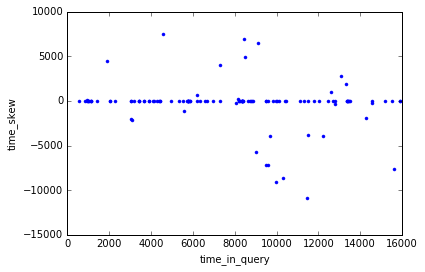

In [177]:
# We can actually break down what match_hashes does to get a little more insight.
# First, return all the hits from the database entries for the hashes present in the query.
hits = database.get_hits(hashes)
# hits has one row per hash hit with columns [id time_skew_ref_query hash time_in_query]
print("hits.shape=", hits.shape)
print("     id  t_skew  hash  t_query")
print(hits[:5])
print("Most common id=", np.argmax(np.bincount(hits[:, 0])), "with #hits=", np.max(np.bincount(hits[:, 0])))
result_rank = 0
top_result_id = results[result_rank, 0]
top_result_t_skew = results[result_rank, 2]
match_hits = np.nonzero(hits[:, 0] == top_result_id)[0]
print("#hits for result #", result_rank, "(id", top_result_id, ")=", len(match_hits))
plot(hits[match_hits, 3], hits[match_hits, 1], '.')
#xlim([8000, 10000])
#ylim([-100, 100])
xlabel('time_in_query')
ylabel('time_skew')
match_hashes = matcher._unique_match_hashes(top_result_id, hits, top_result_t_skew)
# Matching hashes are returned as (time_in_query, hash) rows.
print("match_hashes.shape=", match_hashes.shape)
print(" t_query   hash")
print(match_hashes[:5])

(0, 256)

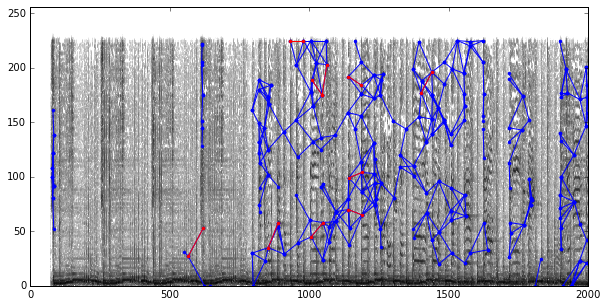

In [129]:
# Plot all the query hashes, then overplot the matching ones in red.
plt.figure(figsize=(10,5))
show_hashes(hashes, d, sr)
show_hashes(match_hashes, color='r')
xlim([0, 2000])
ylim([0, 256])

In [185]:
# We get the audio via the lab's web server.
url_base = 'http://labrosa.ee.columbia.edu:8013/uspop'
url = url_base + '/' + '/'.join(database.names[results[0, 0]].split('/')[-3:])
print(url)
IPython.display.Audio(url=url)

http://labrosa.ee.columbia.edu:8013/uspop/beatles/Abbey_Road/01-Come_Together.mp3


In [186]:
# Read the mp3 file at a URL into the workspace as a waveform.
import urllib2
import tempfile

def read_mp3_from_url(url, sr=None):
    """Read a soundfile from a URL."""
    response = urllib2.urlopen(url)
    mp3data = response.read()
    response.close()
    handle = tempfile.NamedTemporaryFile(delete=False)
    handle.write(mp3data)
    handle.close()
    y, sr = librosa.load(handle.name, sr=sr)
    os.remove(handle.name)
    return y, sr

y, sr = read_mp3_from_url(url)
print(sr, y.shape)

16000 (4171392,)


In [187]:
frame_start = 9300
frame_end = 9700
frame_skew = -4536
data=np.vstack([y[int(frame_start/frame_rate*sr):int(frame_end/frame_rate*sr)][np.newaxis, :],
                y[int((frame_start + frame_skew)/frame_rate*sr):
                  int((frame_end + frame_skew)/frame_rate*sr)][np.newaxis, :]])
print(data.shape)
IPython.display.Audio(data=data, rate=sr)

(2, 102400)


In [144]:
# Define a function to take a waveform and return the matches.
def match_waveform(y, sr, database, analyzer, matcher):
    """Convert waveform to hashes, return match result."""
    peaks = analyzer.find_peaks(y, sr)
    landmarks = np.array(analyzer.peaks2landmarks(peaks))
    query_hashes = audfprint_analyze.landmarks2hashes(landmarks)
    match_results = matcher.match_hashes(database, query_hashes)
    for index, result in enumerate(match_results):
        track_id, match_count, time_offset, raw_count = result[:4]
        print("Match", index, ":", track_name(database, track_id), 
              "aligned", match_count, "of", raw_count, "raw hash matches", 
              "at time offset", time_offset)
    return match_results

results = match_waveform(y, sr, database, analyzer, matcher)    

Match 0 : beatles/Abbey_Road/01-Come_Together aligned 1249 of 1273 raw hash matches at time offset 2
Match 1 : beatles/1/25-Come_Together aligned 29 of 149 raw hash matches at time offset -41
Match 2 : beatles/1/25-Come_Together aligned 28 of 149 raw hash matches at time offset -49
Match 3 : beatles/1/25-Come_Together aligned 20 of 149 raw hash matches at time offset -56
Match 4 : beatles/1/25-Come_Together aligned 20 of 149 raw hash matches at time offset -46
Match 5 : beatles/1/25-Come_Together aligned 19 of 149 raw hash matches at time offset -44
Match 6 : beatles/1/25-Come_Together aligned 15 of 149 raw hash matches at time offset -54


In [150]:
match_waveform(np.hstack([np.zeros(64), y]), sr, database, analyzer, matcher)

Match 0 : beatles/Abbey_Road/01-Come_Together aligned 571 of 599 raw hash matches at time offset 2
Match 1 : beatles/1/25-Come_Together aligned 31 of 162 raw hash matches at time offset -46
Match 2 : beatles/1/25-Come_Together aligned 26 of 162 raw hash matches at time offset -44
Match 3 : beatles/1/25-Come_Together aligned 26 of 162 raw hash matches at time offset -49
Match 4 : beatles/1/25-Come_Together aligned 23 of 162 raw hash matches at time offset -41
Match 5 : beatles/1/25-Come_Together aligned 14 of 162 raw hash matches at time offset -51
Match 6 : beatles/1/25-Come_Together aligned 14 of 162 raw hash matches at time offset -57
Match 7 : beatles/1/25-Come_Together aligned 12 of 162 raw hash matches at time offset -53


array([[7740,  571,    2,  599,    0,    0,    0],
       [4458,   31,  -46,  162,    1,    0,    0],
       [4458,   26,  -44,  162,    1,    0,    0],
       [4458,   26,  -49,  162,    1,    0,    0],
       [4458,   23,  -41,  162,    1,    0,    0],
       [4458,   14,  -51,  162,    1,    0,    0],
       [4458,   14,  -57,  162,    1,    0,    0],
       [4458,   12,  -53,  162,    1,    0,    0]], dtype=int32)